In [1]:
from faker import Faker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
fake = Faker()

num_names = 200

# Generate 50 random first names and surnames
first_names = [fake.first_name() for _ in range(num_names)]
last_names = [fake.last_name() for _ in range(num_names)]

# Set explicit knowledge for example
first_names[:96] = ['Peter']*96
first_names[0] = 'Jan'
last_names[0] = 'Kees'

# Generate 50 random ages that average to 49
age_lower = 2
age_upper = 100
ages = np.random.randint(age_lower, age_upper, num_names)
ages = np.round(ages * (49 * num_names / ages.sum())).astype(int)

ages[0] = 97

# Create the DataFrame
df = pd.DataFrame({
    'first': first_names,
    'last': last_names,
    'age': ages
})

# Display the first few rows and some statistics
print(df.head())
print("\nAge statistics:")
print(df['age'].describe())
print(f"\nAverage age: {df['age'].mean()}")

# Optionally, you can save the DataFrame to a CSV file
# df.to_csv('random_names_ages.csv', index=False)

   first        last  age
0    Jan        Kees   97
1  Peter      Harris   92
2  Peter  Harrington   16
3  Peter       Smith   71
4  Peter       Allen   61

Age statistics:
count    200.000000
mean      49.205000
std       28.694597
min        2.000000
25%       24.000000
50%       51.000000
75%       74.000000
max       97.000000
Name: age, dtype: float64

Average age: 49.205


In [3]:
# Solution 1 [does not work]: only allow 'average' queries
inferred_soln1 = np.mean(df[(df['first'] == 'Jan') & (df['last'] == 'Kees')]['age'])
print(f"[Solution1] Inferred age: {inferred_soln1:.1f}")

# Solution 2: [does not work]: restrict group size
x = np.mean(df[(df['first'] == 'Peter')]['age'])
num_x = len(df[(df['first'] == 'Peter')])
y = np.mean(df[(df['first'] == 'Peter') | (df['last'] == 'Kees')]['age'])
num_y = len(df[(df['first'] == 'Peter') | (df['last'] == 'Kees')])
print(f"x = {x:.1f}, y = {y:.1f}")
print(f"num_x = {num_x}, num_y = {num_y}")

inferred = (num_y * y - num_x * x)
print(f"\n[Solution2] Inferred age: {inferred:.1f}")

[Solution1] Inferred age: 97.0
x = 50.7, y = 51.2
num_x = 95, num_y = 96

[Solution2] Inferred age: 97.0


In [4]:
# Solution 3: Add noise for differential privacy
eps = 1.0
sensitivity = age_upper - age_lower

x = np.mean(df[(df['first'] == 'Peter')]['age'])
num_x = len(df[(df['first'] == 'Peter')])
x_release = x + np.random.laplace(0, sensitivity/(eps*num_x))
print(f"x = {x:.1f}, x_release = {x_release:.1f}")
y = np.mean(df[(df['first'] == 'Peter') | (df['last'] == 'Kees')]['age'])
num_y = len(df[(df['first'] == 'Peter') | (df['last'] == 'Kees')])
y_release = y + np.random.laplace(0, sensitivity/(eps*num_y))
print(f"y = {y:.1f}, y_release = {y_release:.1f}")

inferred = (num_y * y_release - num_x * x_release)
print(f"\n[Solution3] Inferred age: {inferred:.1f}")
print("Try rerunning this cell with different random seeds to see how the inferred age changes.")

x = 50.7, x_release = 49.3
y = 51.2, y_release = 50.8

[Solution3] Inferred age: 198.5
Try rerunning this cell with different random seeds to see how the inferred age changes.


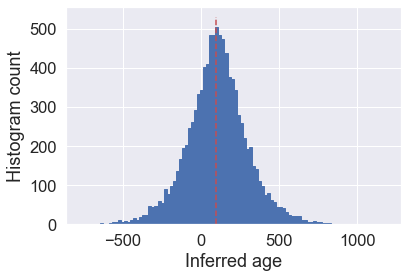

In [5]:
# Make an empirical plot of the released valued.
# Note: in the DP setting, one would have only access to one draw instead of 1000.
sns.set(style='ticks'); sns.set(font_scale=1.5)
num_sample = 10000

x_release = x + np.random.laplace(0, sensitivity/(eps*num_x), size=num_sample)
y_release = y + np.random.laplace(0, sensitivity/(eps*num_y), size=num_sample)

inferred = (num_y * y_release - num_x * x_release)
plt.hist(inferred, bins=100, edgecolor='b'); ax = plt.gca()
plt.plot([inferred_soln1, inferred_soln1], ax.get_ylim(), 'r--', label='Solution 1')
plt.xlabel("Inferred age")
plt.ylabel("Histogram count")
plt.show()

## True Positive and Missed Detection by Adversary

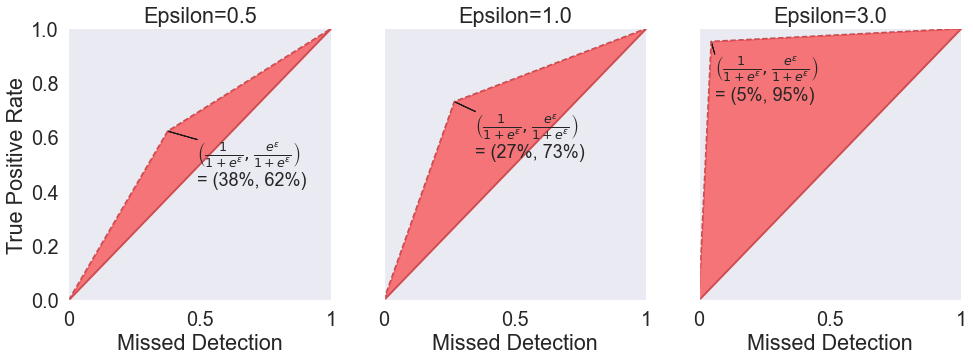

In [20]:
# No delta!
sns.set(style='darkgrid')
sns.set(font_scale=1.8)

# Define epsilon
eps_array = np.array([0.5, 1., 3.])

# Plot the region
fig, axarr = plt.subplots(1, len(eps_array), figsize=(16, 5), sharey=True)

for num_plot, ax in enumerate(axarr):
  epsilon = eps_array[num_plot]

  # Define the boundaries
  x1 = np.linspace(0, 1, 1000)
  y1 = np.exp(epsilon) * x1
  y2 = 1. - (1 - x1) / np.exp(epsilon)
  y3 = np.min([y1, y2], axis=0)
  y_straight = x1

  ax.plot(x1, y_straight, 'r')
  ax.plot(x1, y3, 'r--')
  ax.fill_between(x1, y_straight, y3, color='red', alpha=0.5)


  # Add annotations

  multx = 1.3
  multy = 0.95
  x_start = 1 / (1 + np.exp(epsilon))
  y_start = 1 - 1 / (1 + np.exp(epsilon))
  ax.text(
    multx*x_start, multy*y_start,
    r'$\left(\frac{1}{1+e^\epsilon}, \frac{e^\epsilon}{1+e^\epsilon}\right)$'
    +f'\n= ({100/(1+np.exp(epsilon)):.0f}%, {100.-100/(1+np.exp(epsilon)):.0f}%)', fontsize=18, verticalalignment='top', horizontalalignment='left')

  # Add arrow to figure from (0.5,0.5) to origin
  ax.arrow(multx*x_start, multy*y_start, (x_start - multx*x_start), (y_start - multy*y_start), fc='k', ec='k', length_includes_head=True)  # head_width=0.05, head_length=0.1*mult

  # Add labels and title
  ax.set_title(f'Epsilon={epsilon:.1f}')  # , fontsize=16

  # Remove spines
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  # Remove grid lines
  ax.yaxis.grid(False)
  ax.xaxis.grid(False)

  ax.set_xlim([0, 1])
  ax.set_ylim([0, 1])

  ax.set_xlabel(r'Missed Detection')  # , fontsize=14
  ax.set_xticks([0, 0.5, 1])
  ax.set_xticklabels(['0', '0.5', '1'])
axarr[0].set_ylabel(r'True Positive Rate')  # , fontsize=14

plt.savefig('adversary_tpr.jpg', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'True Positive Rate')

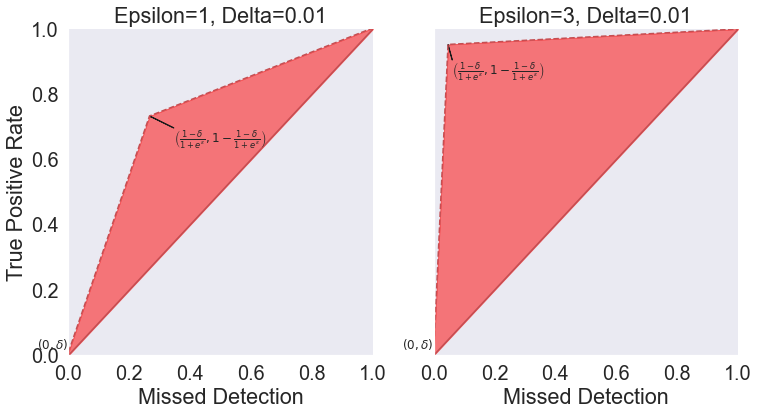

In [7]:
# True positive rates with delta includes
sns.set(style='darkgrid'); sns.set(font_scale=1.8)

# Define epsilon and delta
eps_array = np.array([1., 3.])
delta = 0.01

# Plot the region
fig, axarr = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for num_plot, ax in enumerate(axarr):
  epsilon = eps_array[num_plot]

  # Define the boundaries
  x1 = np.linspace(0, 1, 1000)
  y1 = delta + np.exp(epsilon) * x1
  y2 = 1. - (1 - delta - x1) / np.exp(epsilon)
  y3 = np.min([y1, y2], axis=0)
  y_straight = x1

  ax.plot(x1, y_straight, 'r')
  ax.plot(x1, y3, 'r--')
  ax.fill_between(x1, y_straight, y3, color='red', alpha=0.5)


  # Add annotations
  ax.text(0, delta, r'$(0, \delta)$', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

  multx = 1.3
  multy = 0.95
  x_start = (1 - delta) / (1 + np.exp(epsilon))
  y_start = 1 - (1 - delta) / (1 + np.exp(epsilon))
  ax.text(multx*x_start, multy*y_start,
          r'$\left(\frac{1-\delta}{1+e^\epsilon}, 1 - \frac{1-\delta}{1+e^\epsilon}\right)$', fontsize=12, verticalalignment='top', horizontalalignment='left')

  # Add arrow to figure from (0.5,0.5) to origin
  ax.arrow(multx*x_start, multy*y_start, (x_start - multx*x_start), (y_start - multy*y_start), fc='k', ec='k', length_includes_head=True)  # head_width=0.05, head_length=0.1*mult

  # Add labels and title
  ax.set_title(f'Epsilon={epsilon:.0f}, Delta={delta:.2f}')  # , fontsize=16

  # Remove spines
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  # Remove grid lines
  ax.yaxis.grid(False)
  ax.xaxis.grid(False)

  ax.set_xlim([0, 1])
  ax.set_ylim([0, 1])

  ax.set_xlabel(r'Missed Detection')  # , fontsize=14
axarr[0].set_ylabel(r'True Positive Rate')  # , fontsize=14

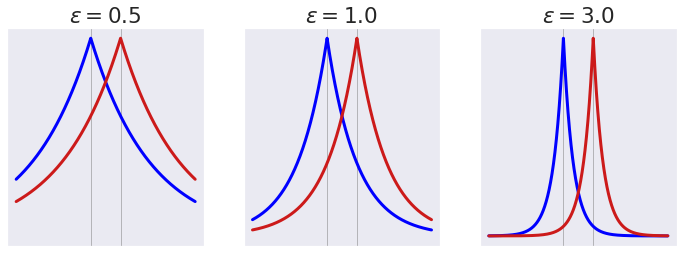

In [14]:
sns.set(style='darkgrid')
sns.set(font_scale=1.8)

b_params = [2.0, 1.0, 0.33]

fig, axarr = plt.subplots(1, len(b_params), figsize=(12, 4), sharey=True)

# Redefine the red color to a softer tone
soft_red = (.8, 0.1, 0.1)
soft_blue = (.1, 0.1, 0.8)

linewidth = 3.

# X-axis values
x = np.linspace(-3, 3, 5000)

# Parameters for two Laplace distributions
mu1 = -0.5  # Mean and scale for first distribution (blue)
mu2 = 0.5  # Mean and scale for second distribution (red)
for i, (ax, b_param) in enumerate(zip(axarr, b_params)):
    # Laplace distribution PDFs
    y1 = stats.laplace.pdf(x, mu1, b_param)
    y2 = stats.laplace.pdf(x, mu2, b_param)

    y1 = y1 / np.max(y1)
    y2 = y2 / np.max(y2)

    # Plt vertical line at 0
    ax.axvline(-0.5, color='gray', linewidth=1, alpha=0.5)
    ax.axvline(0.5, color='gray', linewidth=1, alpha=0.5)


    # Plot
    ax.plot(x, y1, color='blue', linewidth=linewidth)
    ax.plot(x, y2, color=soft_red, linewidth=linewidth)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax.set_title(f"$ \epsilon= {1/b_param:.1f} $")


plt.savefig('laplace_distributions.jpg', dpi=300, bbox_inches='tight')

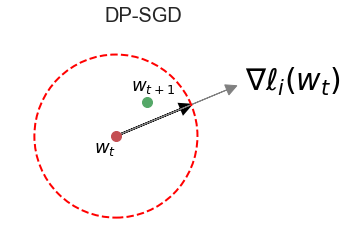

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots()
fontsize = 18

# Parameters for the diagram
C = 1.5  # Radius of the circle (clipping threshold)
w_t = np.array([0, 0])  # Position of w_t
g_t = np.array([1.2, 0.5])  # Gradient g_t
w_t1 = w_t + 0.65 * g_t  # Position of w_t+1
noise = np.array([-0.2, 0.3])  # Noise vector
K = 1.7  # Norm of original gradient

# Create a circle representing the clipping threshold
circle = plt.Circle(w_t, C, color='red', fill=False, linewidth=2, linestyle='--')

# Plot points for w_t, w_t+1, w_t-1
ax.plot(w_t[0], w_t[1], 'ro', markersize=10, label='$w_t$')
ax.plot(w_t1[0]+noise[0], w_t1[1]+noise[1], 'go', markersize=10, label='$w_{t+1}$')

# Plot arrows for gradients g_t and g_t-1
ax.arrow(w_t[0], w_t[1], g_t[0], g_t[1], head_width=0.2, head_length=0.2, fc='black', ec='black', linewidth=2)  # Clipped
ax.arrow(w_t[0], w_t[1], K*g_t[0], K*g_t[1], head_width=0.2, head_length=0.2, fc='gray', ec='gray', linewidth=1)  # unclipped

# Set labels and title
ax.add_artist(circle)
ax.text(w_t[0] - 0.4, w_t[1] - 0.3, r'$w_t$', fontsize=fontsize, color='black')
ax.text(w_t1[0]+noise[0]-0.3, w_t1[1]+noise[1]+0.22, r'$w_{t+1}$', fontsize=fontsize, color='black')
ax.text(K*(g_t[0]+0.2), K*g_t[1], r'$\nabla \ell_i(w_t)$', fontsize=int(1.7*fontsize), color='black')

# Set axis limits
ax.set_xlim([-2, 3])
ax.set_ylim([-2, 2])

# Title and remove axis
plt.title('DP-SGD', fontsize=20)
ax.set_aspect('equal', 'box')
ax.axis('off')

# Show the plot
plt.savefig('dp_sgd.jpg', dpi=300, bbox_inches='tight')
